In [1]:
#현재 위치 확인
!pwd

/content


In [2]:
#ACGPN 모델 파일 다운로드
!git clone https://github.com/kairess/ACGPN.git

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 14.44 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
%cd ACGPN

/content/ACGPN


dependencies 및 사전 파일 준비

In [4]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 14.6 MB/s eta 0:00:00


In [5]:
import gdown
import numpy as np
from PIL import Image
import IPython
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [6]:
#모델을 돌리기 위한 파일 준비
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [7]:
#현재 위치 확인
!pwd

/content/ACGPN


In [8]:
#휴먼 세그멘테이션 모델 파일 다운로드
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 769 (delta 72), reused 62 (delta 62), pack-reused 658
Receiving objects: 100% (769/769), 3.80 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (189/189), done.


사전학습 모델 다운로드

In [9]:
#포즈 예측 모델
!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
From (redirected): https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko&confirm=t&uuid=ab204a21-8990-4034-80a9-16ec0176a810
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:07<00:00, 28.0MB/s]


In [10]:
#휴먼 세그멘테이션 모델
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=60a6b4f9-07fe-46b8-a597-8a68851d1a4f
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:02<00:00, 111MB/s] 


'lip_final.pth'

In [11]:
#모델 데이터셋이 올바른 위치에 있는지 확인
sorted(os.listdir('inputs/img'))

['000066_0.jpg']

In [13]:
#전처리 할 모델 데이터 이름을 시간으로 지정
img_name = f'img_{int(time.time())}.png'

#전처리 할 모델 데이터의 파일 위치 확인
img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])

#이미지 할당
img = Image.open(img_path)

#이미지 크기 변환 및 RGB 색공간으로 변환
img = img.resize((192,256), Image.BICUBIC)

#전처리를 위해 모델 이미지 파일의 위치값을 해당 파일 위치에 지정해준 모델 데이터 이름으로 지정
img_path = os.path.join('Data_preprocessing/test_img', img_name)

#지정해준 모델 이미지 파일의 위치값을 바탕으로 이미지 저장
img.save(img_path)

#전처리를 위해 휴먼 세그멘테이션 모델을 parser를 이용하여 돌림 
#터미널에 입력되도록하는 코드로 변환해야함
#parser는 데이터셋의 종류, 사전학습 모델 파일의 위치, 전처리 할 모델 이미지 위치, 전처리 후 이미지 저장할 위치
!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

#모델 포즈 예측 모델을 돌리고 저장할 파일 위치와 파일 이름 형식을 지정
pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

#모델 포즈 예측 모델을 전처리 할 모델 이미지 위치, 전처리 후 파일 위치를 받아서 돌리고 저장
generate_pose_keypoints(img_path, pose_path)

100% 1/1 [00:06<00:00,  6.80s/it]
File saved at Data_preprocessing/test_pose/img_1681220345_keypoints.json


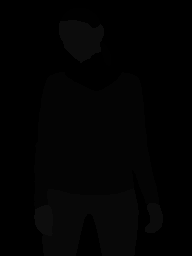

In [14]:
#결과 확인을 위해 전처리 된 모델 이미지 파일을 열어봄
#성공한 겁니다.. 잘보면 회색보임
Image.open(f'Data_preprocessing/test_label/{img_name}')